In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

# .py
import alphas, costs, model

/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


running model
getting cost from nweek ahead
getting alphas ...
done getting alphas ...


In [2]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask].cases
    test_mask = (data.index > "2011")
    test = data[test_mask].cases
    return train, test

In [3]:
provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)

cr_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangRai'].resample('W').size()
cr_dengues_df = pd.DataFrame(cr_dengues,columns=['cases'])
cr_train_test = split_data(cr_dengues_df)
cr_dengues_train, cr_dengues_test = cr_train_test[0], cr_train_test[1]

cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])
cm_train_test = split_data(cm_dengues_df)
cm_dengues_train, cm_dengues_test = cm_train_test[0], cm_train_test[1]

all_dengues = provinces_df.resample('W').size()
all_dengues_df = pd.DataFrame(all_dengues,columns=['cases'])
all_train_test = split_data(all_dengues_df)
all_dengues_train, all_dengues_test = all_train_test[0], all_train_test[1]

In [4]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot(range(len(real)),real,'-r',label=real_legend)
    plt.plot(range(start_week,len(predictions)+start_week),predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)
    
def seperate_train_test(all_data,train_data):
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,700,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+150,700,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)

$$\Omega\,(w_{i}\cdot x_{i}) = \sum_{i=0}^{n} w_{i} x_{i}$$

$$Seasonal\,Part_{0} =\,\cos^2(\dfrac{\pi}{52}\,(x - c)) + k$$

$$cases = \Omega(w\cdot x) \,\times Seasonal\,Part$$

see whether which seasonality model gives a better result

## Poisson for cost function
- represents how many sigma is it away from mean

### def get_alphas(LAG, train, constant)
function takes in amount of LAG for training, data to train, and starting point for constant
- the function returns set of alphas

each lag yields different accuracy, so it'd be best to see whether which lag gives the best fit with the real plot

In [ ]:
# all_26 = alphas.get_alphas(26,all_dengues_train)
# cm_26 = alphas.get_alphas(26,cm_dengues_train)
cm_52 = alphas.get_alphas(52,cm_dengues_train)
# cm_78 = alphas.get_alphas(78,cm_dengues_train)
# cr_26 = alphas.get_alphas(26,cr_dengues_train)

In [660]:
all_26.x

array([  6.45928872e+00,  -2.81063115e-04,   1.54365360e-02,
        -9.30190436e-03,  -2.61540958e-02,   7.07514435e-03,
        -3.08410385e-03,   1.71667068e-02,  -6.64159216e-03,
         8.62045317e-03,   5.32562563e-03,  -1.23359431e-02,
         3.89337369e-03,  -3.35098785e-02,   6.83985201e-02,
        -4.81220453e-02,   1.56970184e-02,  -1.12371100e-02,
         2.72105526e-02,   1.72681758e-02,  -2.04506612e-02,
        -1.98536403e-03,  -3.70395872e-02,  -1.84335763e-03,
         2.36716668e-02,  -1.60758744e-04,   2.11614536e-01,
         4.06746722e+00,   1.97940382e+01])

In [8]:
cm_26.x

array([  5.48087259e-01,  -2.63662369e-02,   4.16213670e-04,
         1.74701975e-02,   1.46039067e-02,  -3.34046621e-02,
        -1.04234917e-03,   2.07497812e-02,   1.37911979e-02,
        -3.97391629e-03,  -9.07976503e-04,   1.36506804e-02,
        -8.16158062e-02,   8.99601814e-02,   3.34004754e-03,
        -3.41328541e-02,   3.66888247e-02,  -7.28057028e-02,
         5.56451602e-02,   3.13569089e-02,   1.59127299e-02,
         7.86683047e-02,  -4.24985800e-02,  -3.49621527e-02,
         3.03665765e-02,  -2.16616641e-02,   6.44252075e-01,
         7.82812701e-01,   2.01258911e+01])

In [9]:
def plot_prediction(LAG, real, ws, province, nweeks_to_predict=[1,2,4,8,16,52]):

    def n_week_ahead(cases_for_prediction, weeks_ahead, first_week_to_predict):

        cur_prediction = 0
        prev_cases = np.array(cases_for_prediction)
        for i in range(weeks_ahead):
            week_to_predict = first_week_to_predict + i
            cur_prediction = model.guess(ws, week_to_predict, prev_cases)
            prev_cases = np.append(prev_cases[1:],cur_prediction) # deduct the first elm out
        return cur_prediction

    for nweek in nweeks_to_predict: # 1,2,4,8,12
        predictions = []
        for start_week in range(len(real)-LAG):
            first_week_to_predict = start_week + LAG
            cases_for_prediction = real[start_week:first_week_to_predict]
            prediction = n_week_ahead(
                cases_for_prediction,
                nweek,
                first_week_to_predict)
            predictions.append(prediction)
#         return 
        
        title = "%s's Dengue Prediction %d lags: %d week(s) ahead"%(province,LAG,nweek)
        start_predict_week = LAG+(nweek-1)
        make_line(start_predict_week, real, predictions, title, "# week starting 2003","cases")
        seperate_train_test(real,cm_dengues_train)

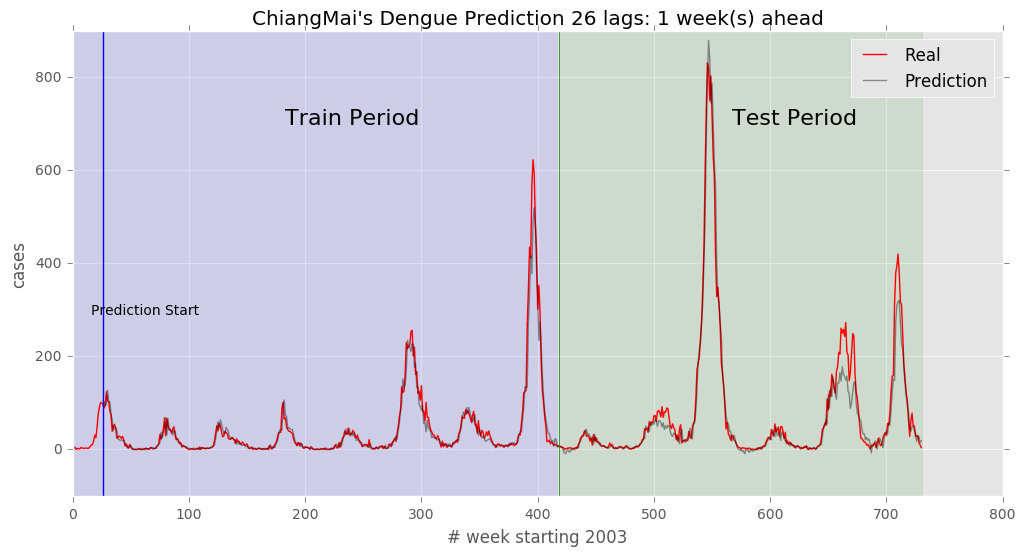

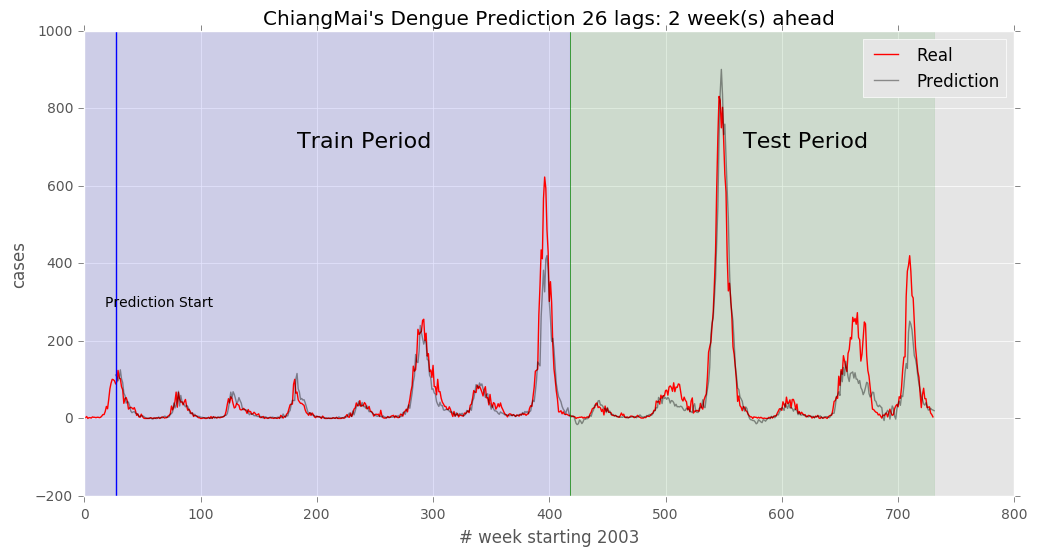

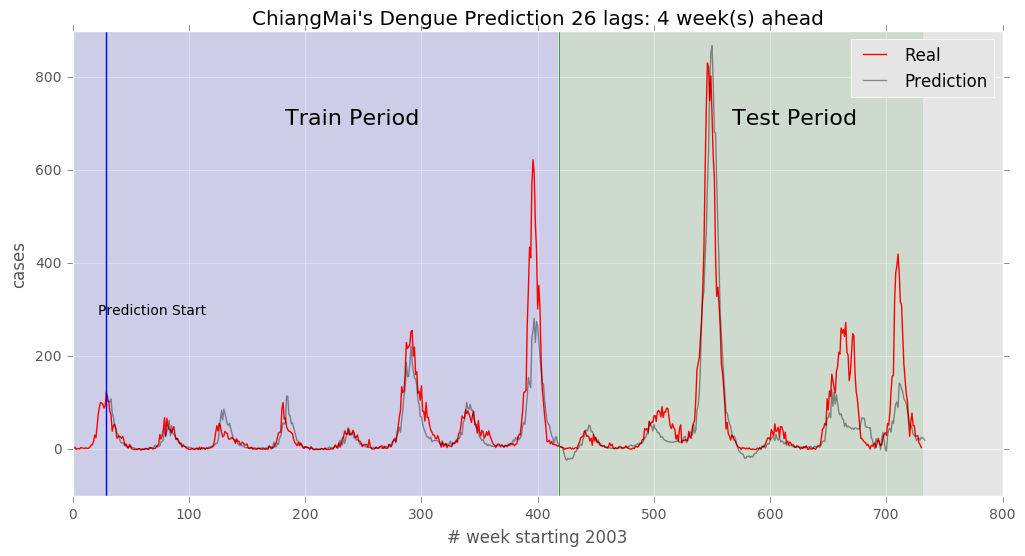

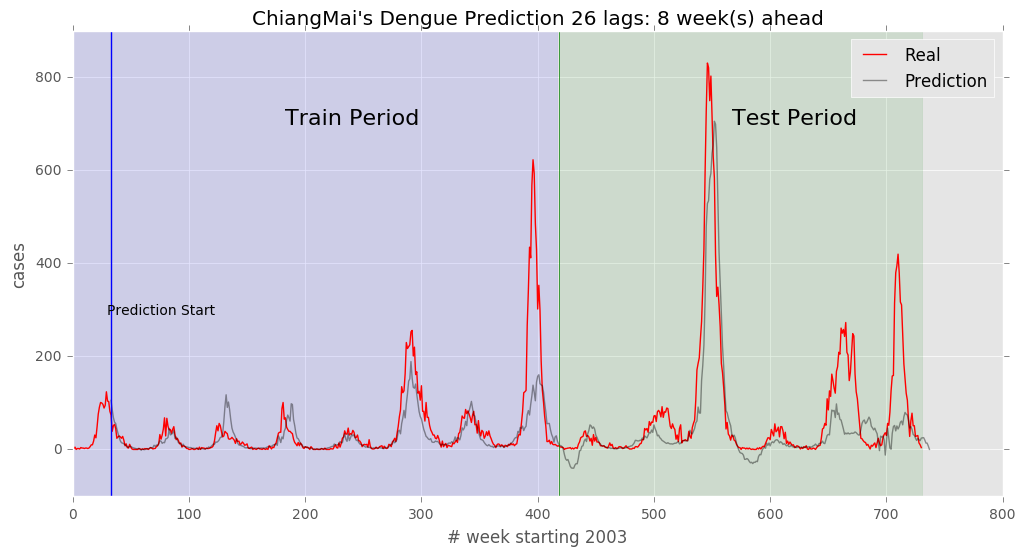

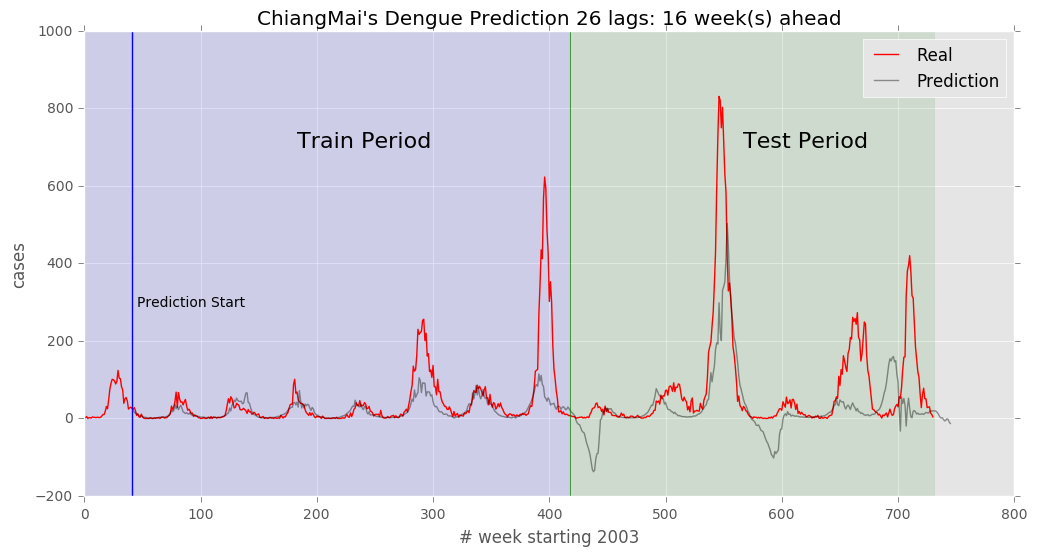

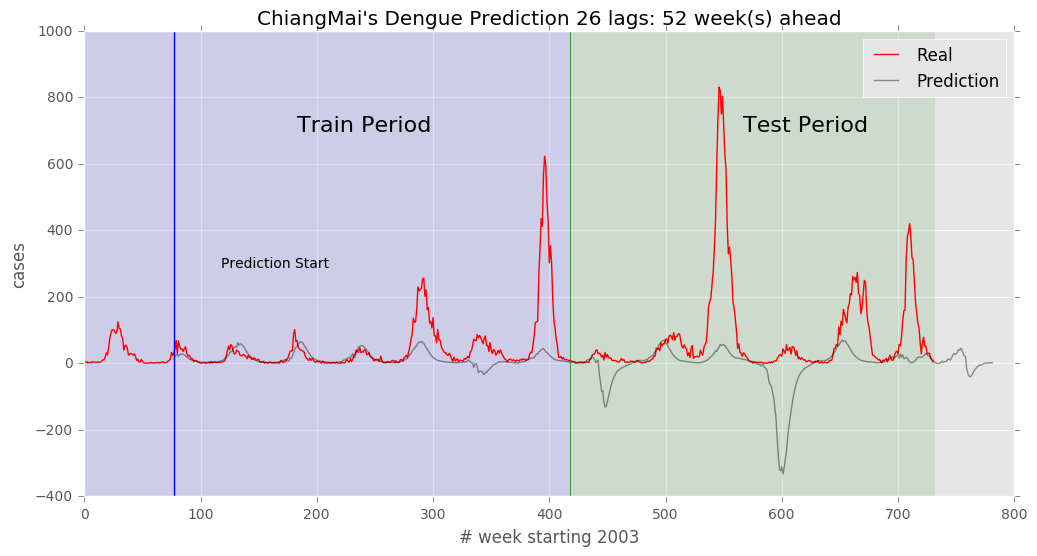

In [10]:
plot_prediction(26,cm_dengues_df.cases,cm_26.x,"ChiangMai")
    

391 417
391 417
391 417
391 417


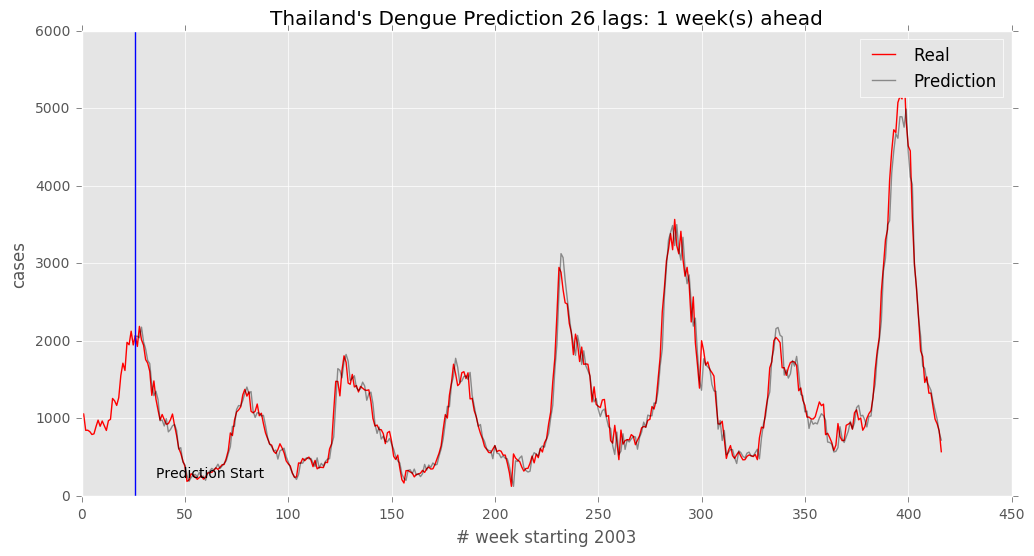

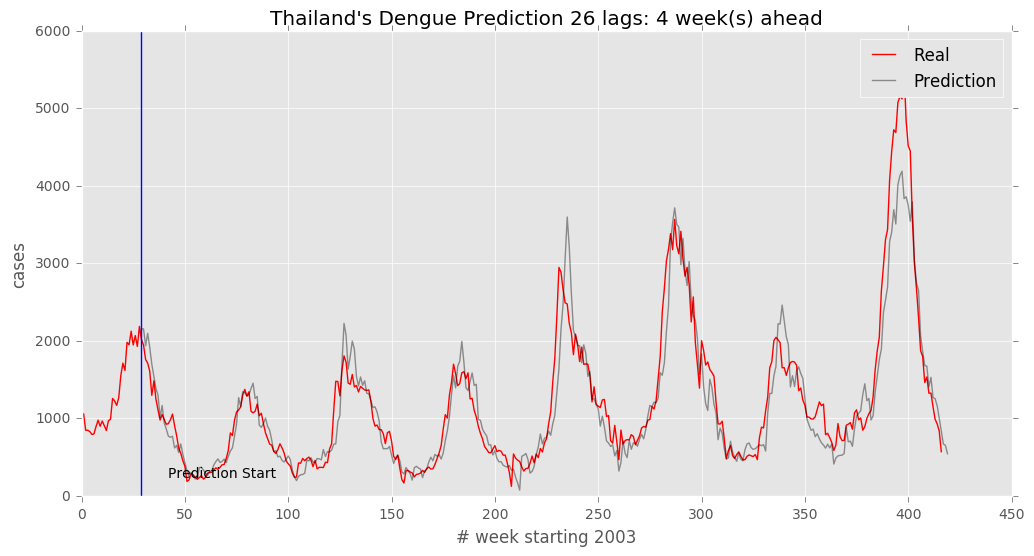

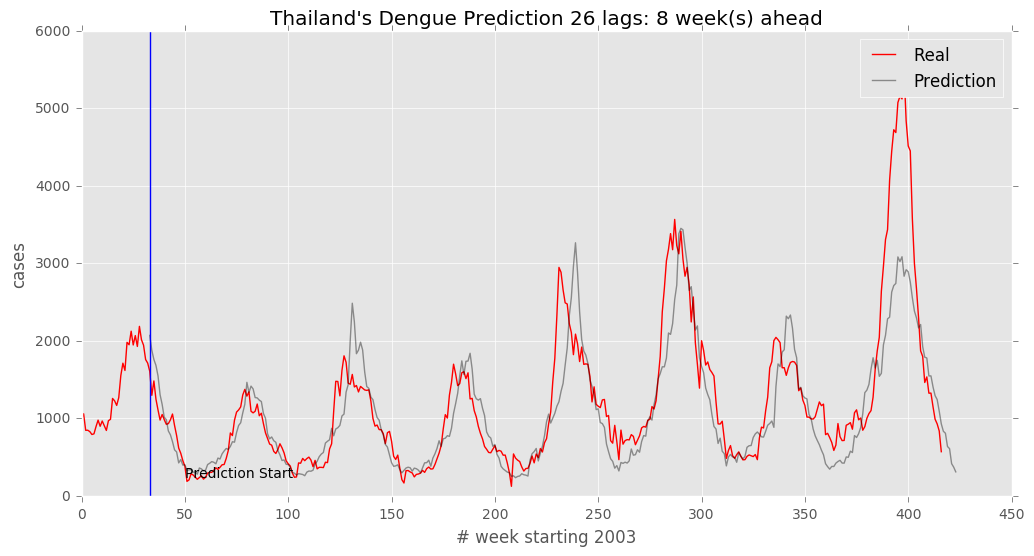

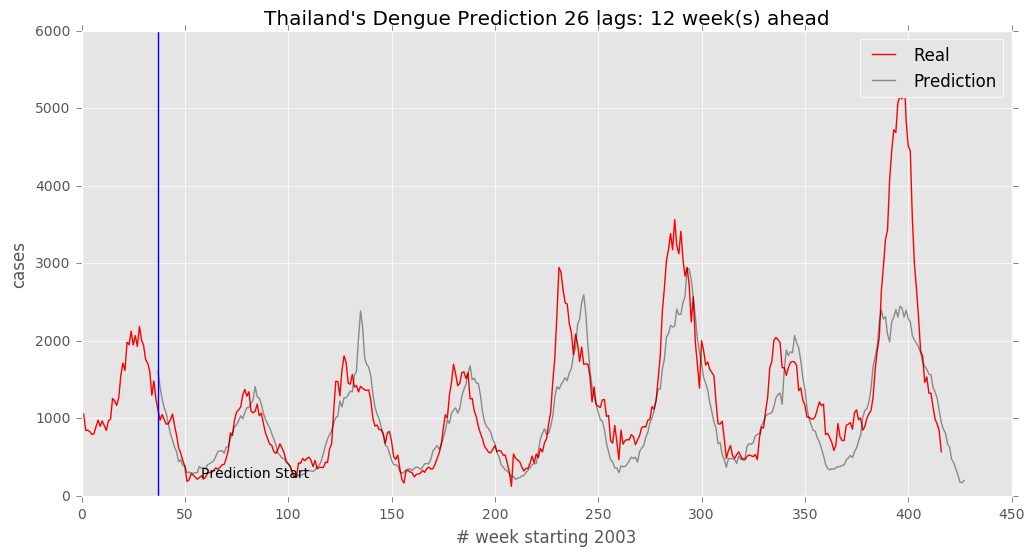

In [637]:
plot_prediction(26,all_dengues_train,all_26.x,"Thailand")

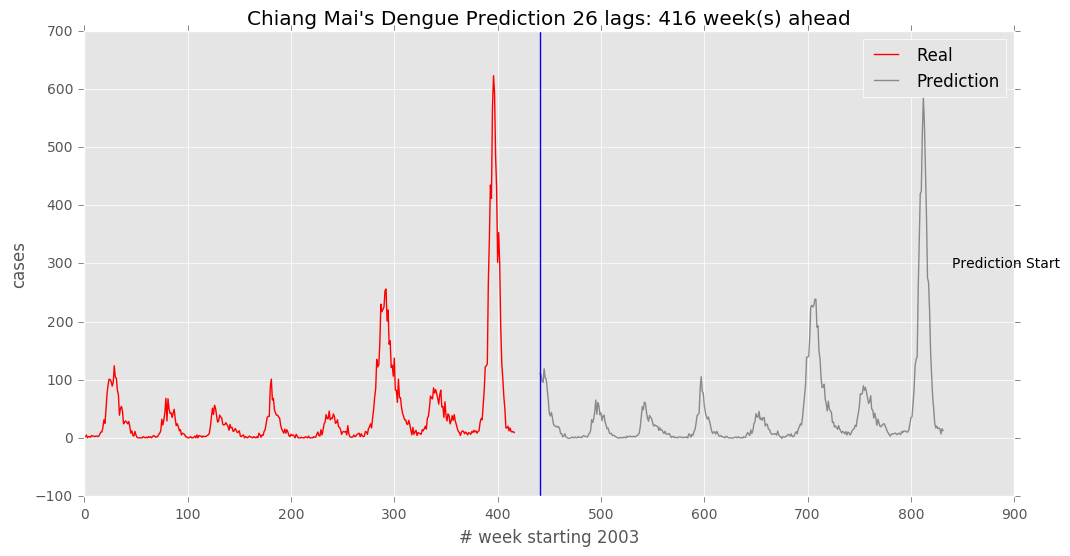

In [339]:
plot_prediction(26,cm_dengues_train,cm_26.x,"Chiang Mai")

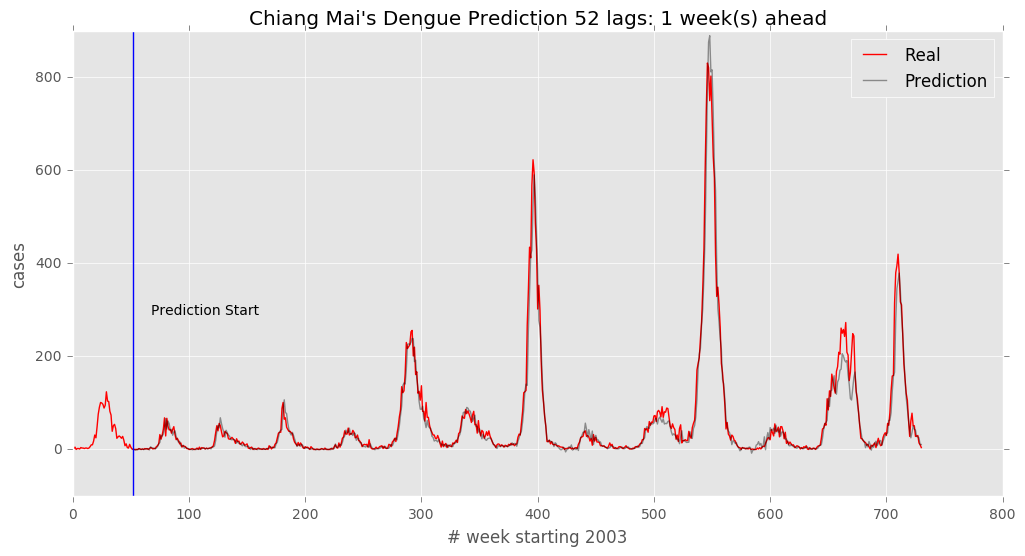

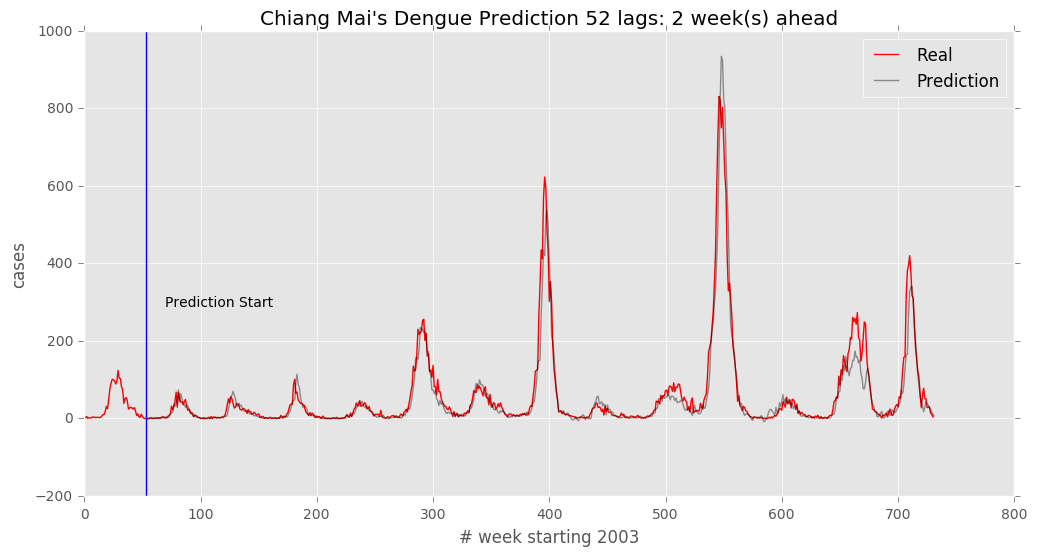

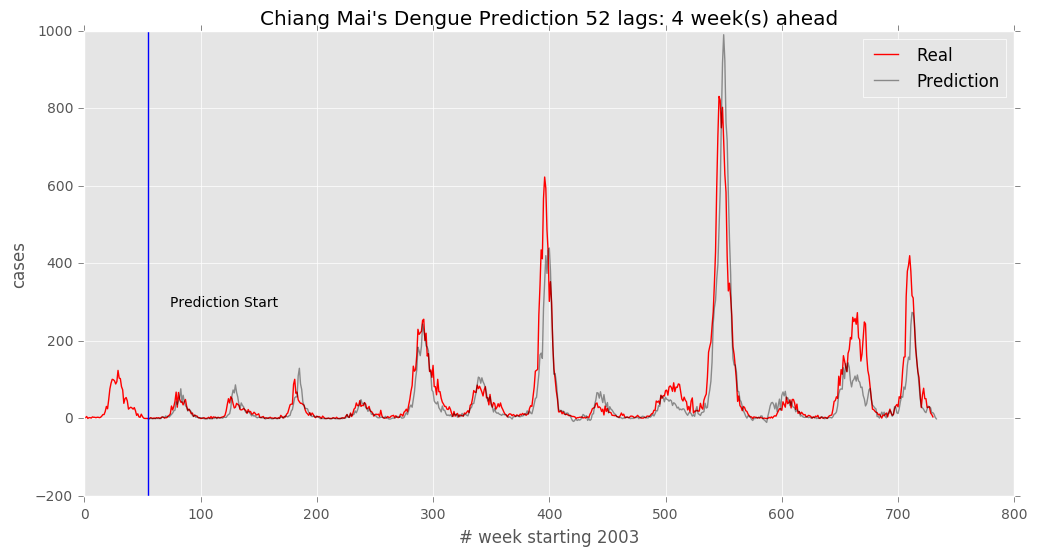

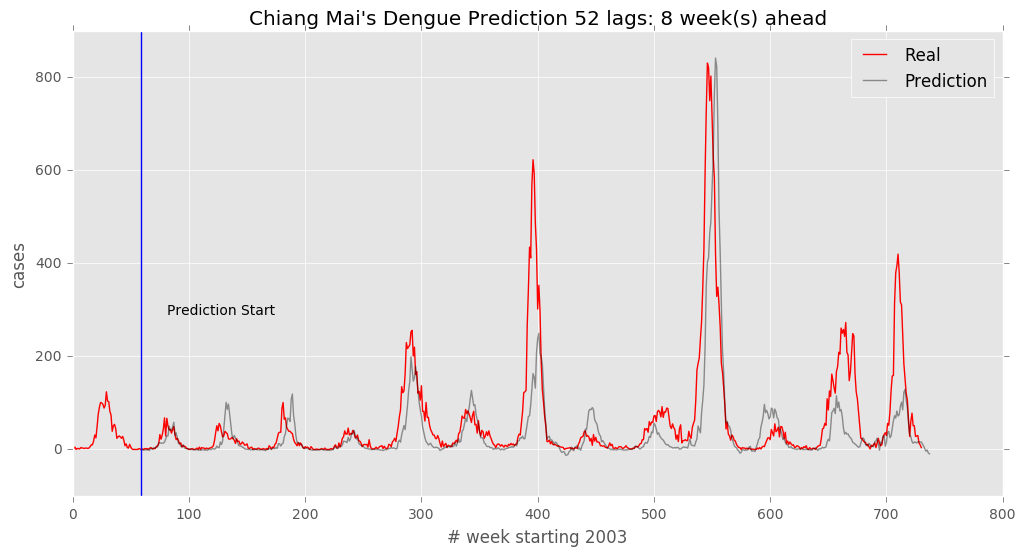

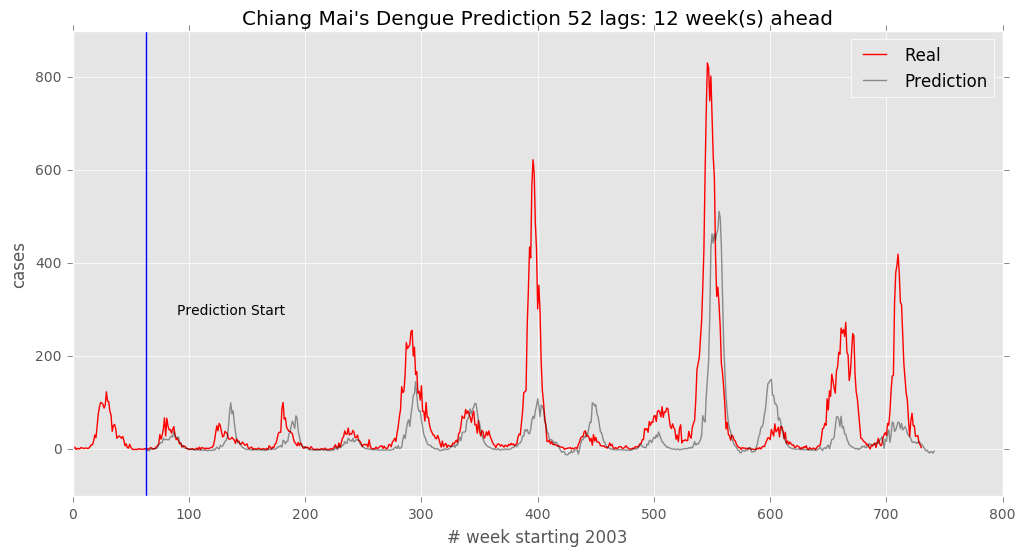

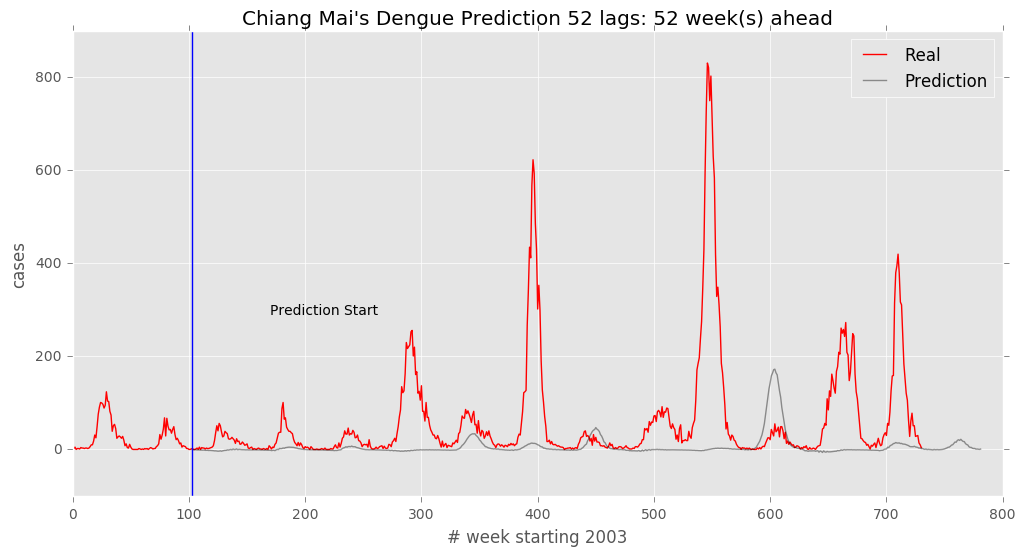

In [232]:
plot_prediction(52,cm_dengues_df.cases,cm_52.x,"Chiang Mai")

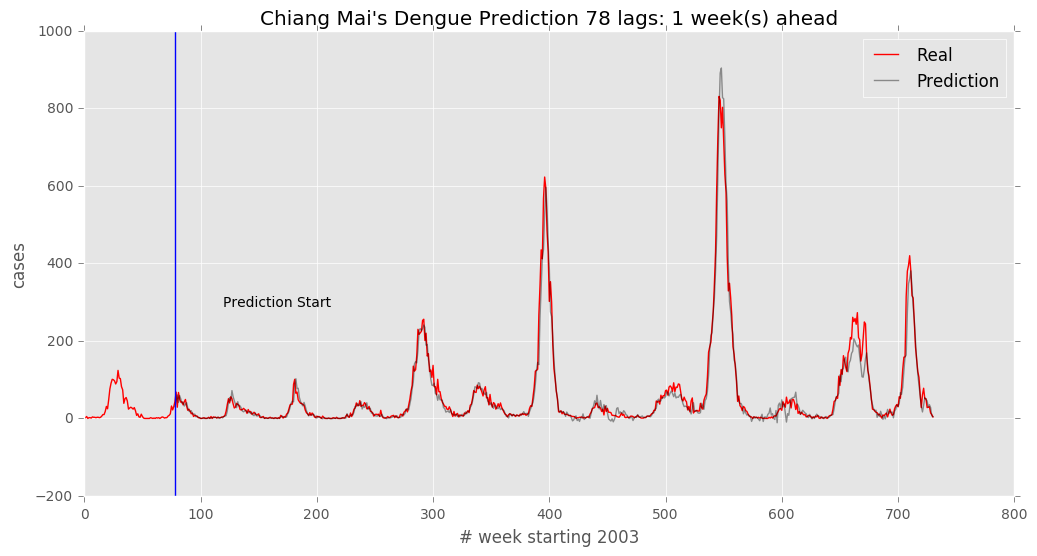

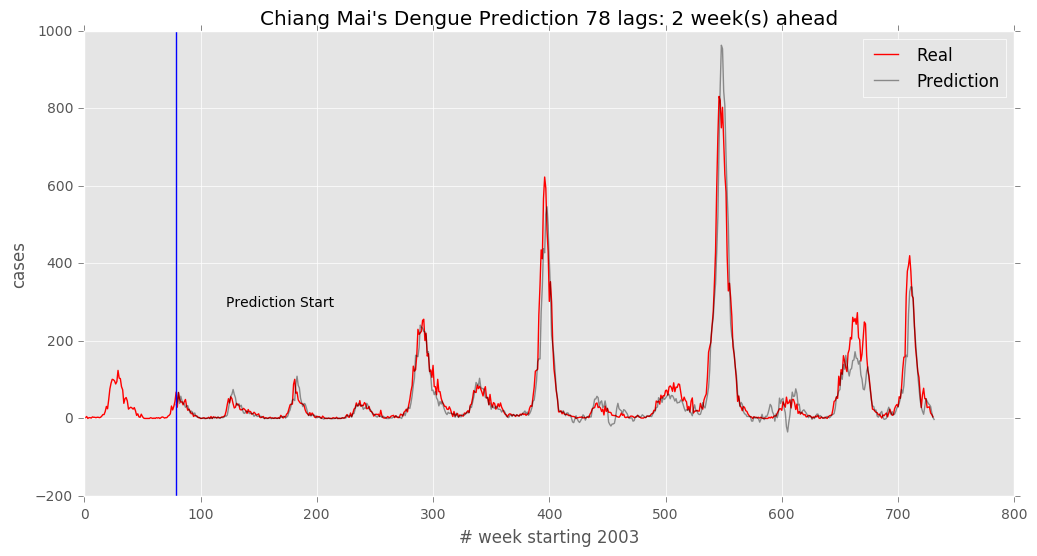

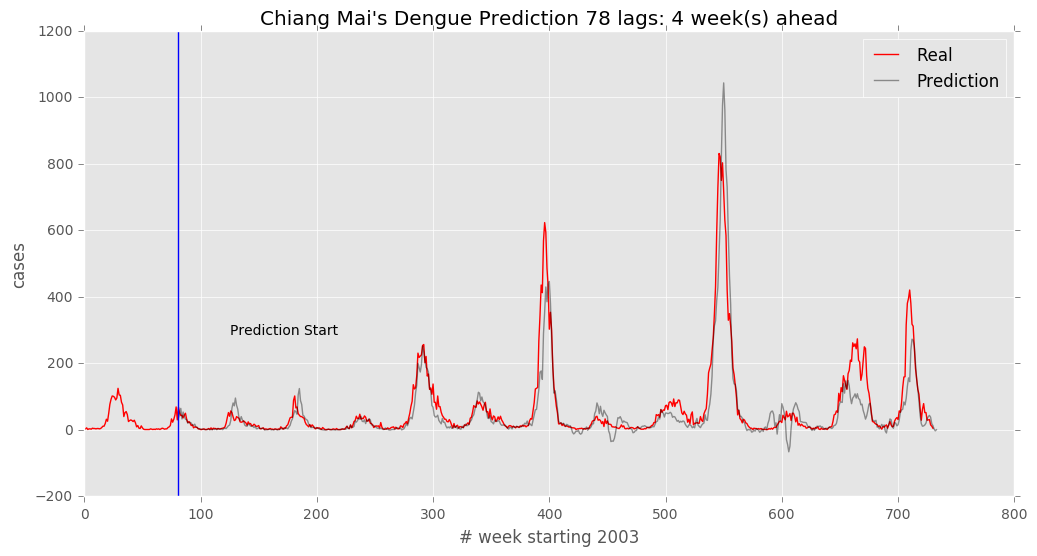

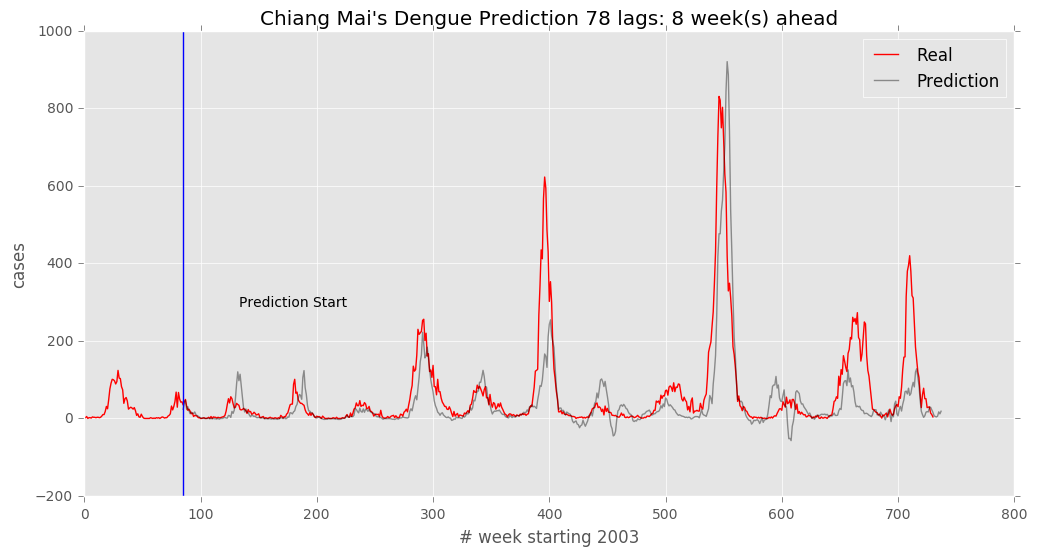

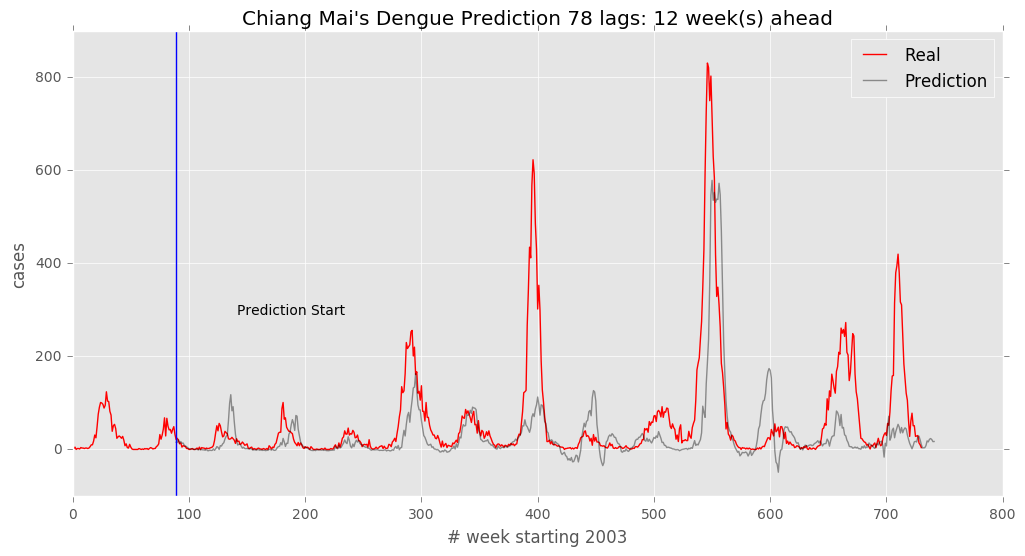

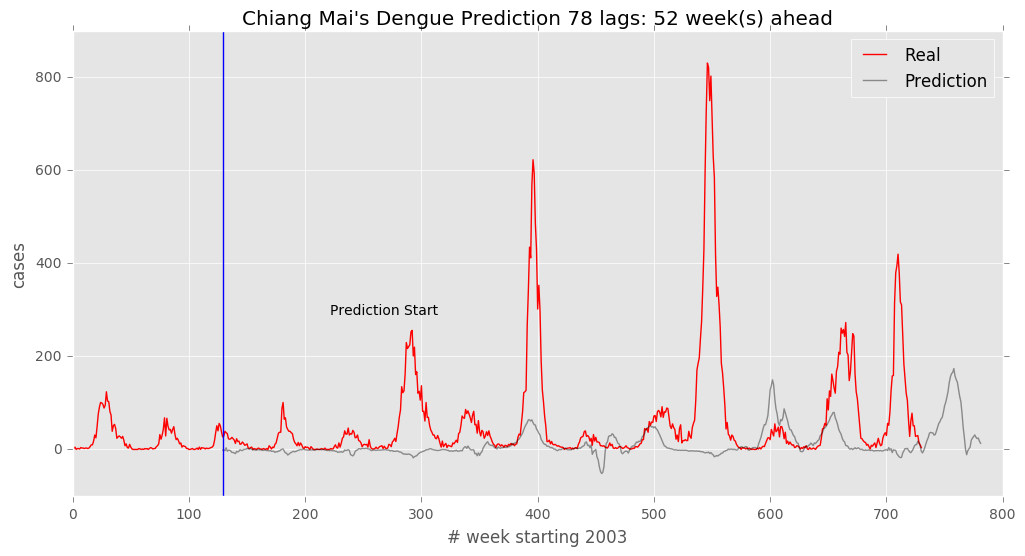

In [233]:
plot_prediction(78,cm_dengues_df.cases,cm_78.x,"Chiang Mai")